In [1]:
# Ressources: https://github.com/slundberg/shap

# Census income classification with LightGBM
This notebook demonstrates how to use LightGBM to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset. To download a copy of this notebook visit github.

Gradient boosting machine methods such as LightGBM are state-of-the-art for these types of prediction problems with tabular style input data of many modalities. Tree SHAP (arXiv paper) allows for the exact computation of SHAP values for tree ensemble methods, and has been integrated directly into the C++ LightGBM code base. This allows fast exact computation of SHAP values without sampling and without providing a background dataset (since the background is inferred from the coverage of the trees).

Here we demonstrate how to use SHAP values to understand LightGBM model predictions.

In [2]:
! pip install -U lightgbm
! pip install -U shap

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

## Load dataset

In [4]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
X_display.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [5]:
y_display

array([False, False, False, ..., False, False,  True])

In [6]:
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [7]:
y

array([False, False, False, ..., False, False,  True])

## Train Test Split

In [8]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [9]:
# Build training and testing dataset for LGB
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

## Train Model

In [10]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params=params, 
                  train_set=d_train,
                  num_boost_round=1000, 
                  valid_sets=[d_test], 
                  early_stopping_rounds=50, 
                  verbose_eval=1000)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.278029


## Explain predictions
Here we use the Tree SHAP implementation integrated into Light GBM to explain the entire dataset (32561 samples).

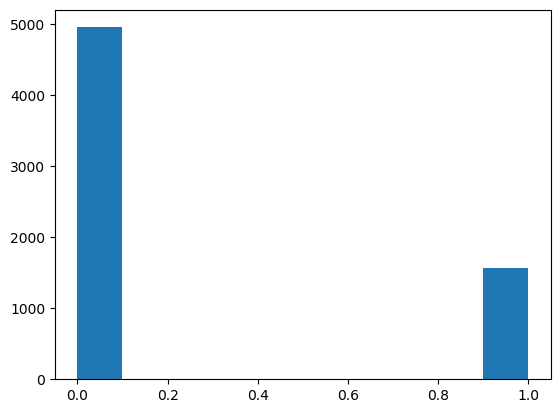

In [11]:
plt.hist(np.where(y_test == False, 0, 1))
plt.show()

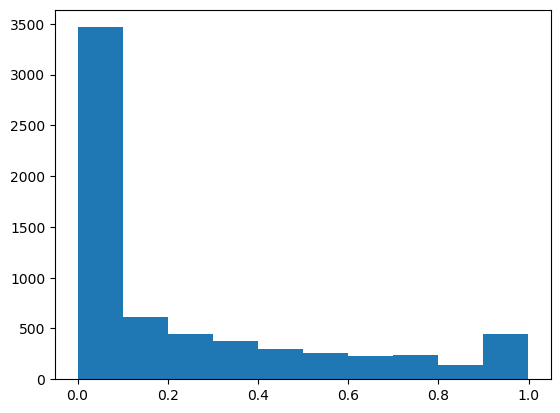

In [12]:
plt.hist(model.predict(X_test))
plt.show()

### Explain predictions using the Tree Explainer Object

In [13]:
explainer = shap.TreeExplainer(model=model, 
                               data=X_train[0:100], # background dataset
                               feature_perturbation="interventional",
                               model_output="probability")
shap_values = explainer.shap_values(X_test)

100%|===================| 6507/6513 [01:09<00:00]        

In [14]:
shap_values.shape

(6513, 12)

### Visualize a single prediction
Note that we use the “display values” data frame so we get nice strings instead of category codes.

In [15]:
observation = 0

y_test[observation]

False

In [16]:
model.predict(X_test.iloc[observation,:])

Converting data to scipy sparse matrix.


array([0.03354713])

In [17]:
# explain single prediction
shap.force_plot(explainer.expected_value, 
                shap_values[observation,:], 
                X_display.iloc[observation,:])

### Visualize many predictions
To keep the browser happy we only visualize 1,000 individuals.

In [18]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])